#  GEE测试程序

## 准备环境

1）服务器装好Python环境，并安装pip<br/>
2）安装Google的Python API客户端<br/>
----pip install google-api-python-client -i http://pypi.douban.com/simple --trusted-host pypi.douban.com<br/>
3）安装鉴权验证依赖库<br/>
----pip install earthengine-api  -i http://pypi.douban.com/simple --trusted-host pypi.douban.com<br/>
4)安装GEE的Python库<br/>
----pip install earthengine-api  -i http://pypi.douban.com/simple --trusted-host pypi.douban.com<br/>

安装 Google Cloud Command Line Interface(gcloud)
5)验证GEE账户<br/>
----earthengine authenticate,获取 authorization code<br/>



<br/>
上述步骤执行一次后，就不用再执行了，服务器环境配置完成<br/>


In [1]:
# -*- coding:utf-8 -*-

## 设置代理端口

In [2]:
import os
# 蚂蚁加速器的端口
# os.environ['HTTP_PROXY'] = 'http://127.0.0.1:1080'
# os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:1080'
# 佛跳墙的端口
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:19180'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:19180'

## 初始化GEE

In [3]:
import ee
ee.Initialize()

## 获取图像信息

In [4]:
import json
data=ee.Image('USGS/SRTMGL1_003').getInfo()
print(json.dumps(data, sort_keys=True, indent=4, separators=(',', ':')))

{
    "bands":[
        {
            "crs":"EPSG:4326",
            "crs_transform":[
                0.0002777777777777778,
                0,
                -180.0001388888889,
                0,
                -0.0002777777777777778,
                60.00013888888889
            ],
            "data_type":{
                "max":32767,
                "min":-32768,
                "precision":"int",
                "type":"PixelType"
            },
            "dimensions":[
                1296001,
                417601
            ],
            "id":"elevation"
        }
    ],
    "id":"USGS/SRTMGL1_003",
    "properties":{
        "date_range":[
            950227200000,
            951177600000
        ],
        "description":"<p>The Shuttle Radar Topography Mission (SRTM, see <a href=\"http://onlinelibrary.wiley.com/doi/10.1029/2005RG000183/full\">Farr\net al. 2007</a>)\ndigital elevation data is an international research effort that\nobtained digital elevation models on

## 获取下载地址

In [5]:
image1 = ee.Image('srtm90_v4')
path = image1.getDownloadUrl({
    'scale': 30,
    'crs': 'EPSG:4326',
    'region': '[[-120, 35], [-119, 35], [-119, 34], [-120, 34]]'
})
#打印空行
print()
print(path)


https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/6372828bf91c925d155cb0ea8c792d61-37c55cd6acc0a2777f4d3c174f54fb96:getPixels


## 获取缩略图

In [6]:
thumb_url=image1.getThumbURL({
    "crs":"EPSG:4326",
    "min":0,
    "max":5000
})
print()
print(thumb_url)
print()
# Import the Image function from the IPython.display module. 
from IPython.display import Image
Image(url=thumb_url)


https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/0ad07c87a2ae0ed9666e6bd2c36315c6-d87745ed47e93e069dfe57e6d719e757:getPixels



In [7]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)
# Display a thumbnail of global elevation.
Image(url = dem.updateMask(dem.gt(0))
  .getThumbURL({'min': 0, 'max': 4000, 'dimensions': 512,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

Mount Everest elevation (m): 8729


## 基于leaflet地图显示影像

In [8]:
# Import the Folium library.
import folium
# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a folium map object.
my_map = folium.Map(location=[20, 0], zoom_start=3, height=500)

# Add the elevation model to the map object.
my_map.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

## 用图表绘制影像统计结果数据

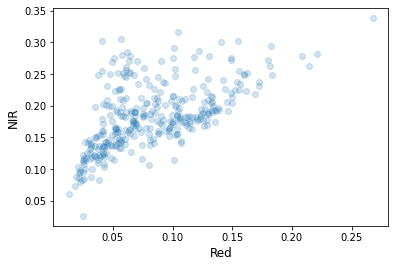

In [9]:
# Import the matplotlib.pyplot module.
import matplotlib.pyplot as plt

# Fetch a Landsat image.
img = ee.Image('LANDSAT/LT05/C01/T1_SR/LT05_034033_20000913')

# Select Red and NIR bands, scale them, and sample 500 points.
samp_fc = img.select(['B3','B4']).divide(10000).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()